In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn.functional as F
from mtgnn import MTGNN
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from pytorch_forecasting.metrics.point import MAPE

from IPython.display import clear_output

In [ ]:
def root_relative_squared_error(y_true, predictions):
  """
  y_true: np.2darray (n_samples, n_outputs)
  predictions: np.2darray (n_samples, n_outputs)
  """

  return np.sqrt(((y_true - predictions)**2).sum(0) / ((y_true - y_true.mean(0))**2).sum(0)).mean()

# About framework

MTGNN (_Miltivariate time series graph neural network_) is a NN that uses GNN architecture to model dependecies between time series. [More about it](https://github.com/AnalyseOptimize/financial_nn_forecasting).

We train MTGNN on stock price history for all stocks at the same time.

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_losses(train_losses, test_losses, train_mape, test_mape):
    clear_output()

    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('MSELoss')

    axs[1].plot(range(1, len(train_mape) + 1), train_mape, label='train')
    axs[1].plot(range(1, len(test_mape) + 1), test_mape, label='test')
    axs[1].set_ylabel('mape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

torch.autograd.set_detect_anomaly(True)
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_mape = 0.0, 0.0
    mape = MAPE()
    model.train()
    for series, target in tqdm(train_loader, desc=tqdm_desc):
        series = series.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        prediction = model(series)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * series.shape[0]
        train_mape += mape.loss(target, prediction).sum().item()
    train_loss /= len(train_loader.dataset)
    train_mape /= len(train_loader.dataset)

    return train_loss, train_mape

@torch.no_grad() # декоратор перед функцией позволяет не считать градиенты
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    mape = MAPE()
    test_loss, test_mape = 0.0, 0.0
    model.eval()
    for series, target in tqdm(test_loader, desc=tqdm_desc):
        series = series.to(device)
        target = target.to(device)

        prediction = model(series)
        loss = criterion(prediction, target)

        test_loss += loss.item() * series.shape[0]
        test_mape += mape.loss(target, prediction).sum().item()
    test_loss /= len(test_loader.dataset)
    test_mape /= len(test_loader.dataset)
    return test_loss, test_mape


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, early_stopping_rounds):
    train_losses, train_mapes = [], []
    test_losses, test_mapes = [], []

    if early_stopping_rounds == None:
      early_stopping_rounds = num_epochs

    best_metric = np.inf
    for epoch in range(1, num_epochs + 1):
      if early_stopping_rounds != 0:
        train_loss, train_mape = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_mape = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        if test_mape > best_metric:
          early_stopping_rounds -= 1
        else:
          best_params = model.parameters()
          best_metric = test_mape

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_mapes += [train_mape]
        test_losses += [test_loss]
        test_mapes += [test_mape]
        plot_losses(train_losses, test_losses, train_mapes, test_mapes)

    return train_losses, test_losses, train_mapes, test_mapes, best_params

In [ ]:
class MTGNN_Dataset(Dataset):
  '''
  For each index returns
  x: [1, num_nodes, seq_len]
  y: [1, num_nodes, 1]
  '''
  def __init__(self, ts, seq_len):
    super().__init__()
    self.ts = ts
    self.y = ts[seq_len:, :]
    self.seq_len = seq_len
    self.total_len, self.m = ts.size()


    # Check that seq_len less or equal total_len
    if self.seq_len > self.total_len:
        raise ValueError("seq_len should be less than or equal to total_len")

    # Number of observations
    self.n = self.total_len - self.seq_len

  def __getitem__(self, index):

    return self.ts[index:index+self.seq_len, :].transpose(1,0)[None, ...], self.y[index, :][None, ..., None]

  def __len__(self):
    return self.n

In [ ]:
df = pd.read_csv('final_fintech.csv')
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(by = 'date', ascending=True)
columns = [col for col in df.columns if 'close' in col] # remain only prices
df = df[columns]

Комментарий: Z-стандартизация показала себя лучше, чем Min-Max. Вторая иногда вызывает взрыв градиентов, хотя для правильного шкалирования нужно использовать именно Min-Max, заранее позаботясь о выбросах.

In [ ]:
def normalize_ts(ts):
  '''
  Z - standartization for miltivariate time series
  ts: torch.Tensor[ts_len, num_nodes]
  '''
  normalized_ts = (ts - ts.mean(dim=0)) / (ts.std(dim=0))
  return normalized_ts

In [ ]:
ts = normalize_ts(torch.FloatTensor(df.values))

seq_len = 50
test_size = 0.1
ts_train = ts[:int(ts.shape[0]*(1-test_size)),:]
ts_test = ts[int(ts.shape[0]*(1-test_size))-seq_len:, :]

In [ ]:
train_dataset = MTGNN_Dataset(ts_train, seq_len)
test_dataset = MTGNN_Dataset(ts_test, seq_len)
train_loader = DataLoader(train_dataset, batch_size = 20)
test_loader = DataLoader(test_dataset)

In [ ]:
model = MTGNN(gcn_true = True,
    build_adj = True,
    dropout = 0.3,
    subgraph_size = 20,
    gcn_depth = 4,
    num_nodes = ts.shape[1], # num_nodes = num_ts
    node_dim = 1,
    dilation_exponential = 1,
    conv_channels = 32,
    residual_channels = 32,
    skip_channels = 64,
    end_channels = 128,
    in_dim = 1,
    seq_length = seq_len,
    layers = 10,
    propalpha = 0.05,
    tanhalpha = 3,
    kernel_size = 7,
    kernel_set = [2, 3, 6, 7],
    layer_norm_affline=True,
    out_dim = ts.shape[1])
model.to(device);

In [ ]:
num_epochs = 200
optimizer = Adam(model.parameters())
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # scheduler for dynamic lr

In [ ]:
_,_,_,_, best_params = train(model, optimizer, scheduler = None, \
      criterion = criterion, train_loader = train_loader, \
      test_loader = test_loader, num_epochs = num_epochs, early_stopping_rounds=None)

In [ ]:
predictions = []
y_true = []
with torch.no_grad():
  for x, y in test_loader:
    x,y = x.to(device), y.to(device)
    model.eval()
    predictions.append(model(x)[0,0, :,:])
    y_true.append(y[0,0, :,:])

y_true = np.array([element.reshape(-1).cpu().numpy() for element in y_true])
predictions = np.array([element.reshape(-1).cpu().numpy() for element in predictions])

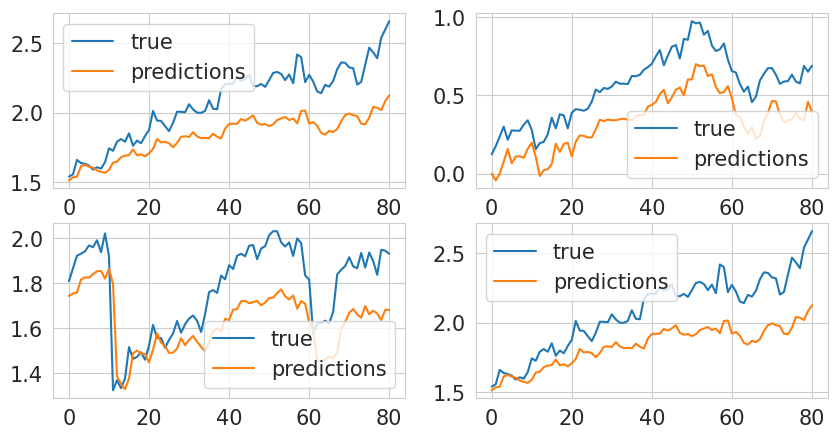

In [ ]:
# Visualise for 4 first prices
fig, ax = plt.subplots(2,2, figsize = (10,5))

ax[0,0].plot(y_true[:,0], label = 'true')
ax[0,0].plot(predictions[:,0], label = 'predictions')
ax[0,0].legend()

ax[0,1].plot(y_true[:,1], label = 'true')
ax[0,1].plot(predictions[:,1], label = 'predictions')
ax[0,1].legend()

ax[1,0].plot(y_true[:,2], label = 'true')
ax[1,0].plot(predictions[:,2], label = 'predictions')
ax[1,0].legend()

ax[1,1].plot(y_true[:,0], label = 'true')
ax[1,1].plot(predictions[:,0], label = 'predictions')
ax[1,1].legend();

In [ ]:
def validate_model(y_true, predictions):

  mape = mean_absolute_percentage_error(y_true, predictions)
  mse = mean_squared_error(y_true, predictions)
  rmse = np.sqrt(mse)
  rrse = root_relative_squared_error(y_true, predictions)

  (n,m) = y_true.shape
  corr = 0
  for i in range(m):
    corr += np.corrcoef(y_true[:,i], predictions[:,i])[1,0]

  corr /= m

  return mape, mse, rmse, rrse, corr


def print_metrics(mape, mse, rmse, rrse, corr):

  print('MAPE:', mape)
  print('MSE:', mse)
  print('RMSE:', rmse)
  print('RRSE:', rrse)
  print('Correlation coef:', corr)

In [ ]:
print_metrics(*validate_model(y_true, predictions))

MAPE: 2.2685397
MSE: 0.17821103
RMSE: 0.4221505
RRSE: 1.523511
Correlation coef: 0.9061998562873824


On the figure above one can see that predictions are very correlated with real values (correlation = 0.91), but not scaled enough. Luckely, we can easily improve that with simple linear regression with stacking technique.

In [ ]:
# saving model
# 5 layers, gcn_depth = 4
torch.save(model.state_dict(), 'mtgnn_190epochs')

In [ ]:
# loading model
# model = MTGNN(*args, **kwargs)
# model.load_state_dict(torch.load(SAVE_PATH))
# model.eval()

## Predicting on test data


In [ ]:
model = MTGNN(gcn_true = True,
    build_adj = True,
    dropout = 0.3,
    subgraph_size = 2,
    gcn_depth = 4,
    num_nodes = ts.shape[1], # num_nodes = num_ts
    node_dim = 1,
    dilation_exponential = 1,
    conv_channels = 16,
    residual_channels = 32,
    skip_channels = 64,
    end_channels = 128,
    in_dim = 1,
    seq_length = seq_len,
    layers = 5,
    propalpha = 0.05,
    tanhalpha = 3,
    kernel_size = 7,
    kernel_set = [2, 3, 6, 7],
    layer_norm_affline=True,
    out_dim = ts.shape[1])
model.to(device);
model.load_state_dict(torch.load('mtgnn_190epochs', map_location=torch.device('cpu')))
model.eval()

In [ ]:
predictions = []
y_true = []
with torch.no_grad():
  for x, y in test_loader:
    x,y = x.to(device), y.to(device)
    model.eval()
    predictions.append(model(x)[0,0, :,:])
    y_true.append(y[0,0, :,:])

y_true = np.array([element.reshape(-1).cpu().numpy() for element in y_true])
predictions = np.array([element.reshape(-1).cpu().numpy() for element in predictions]) # times, n_ts

In [ ]:
np.save('predictions_MTGNN.npy', predictions)

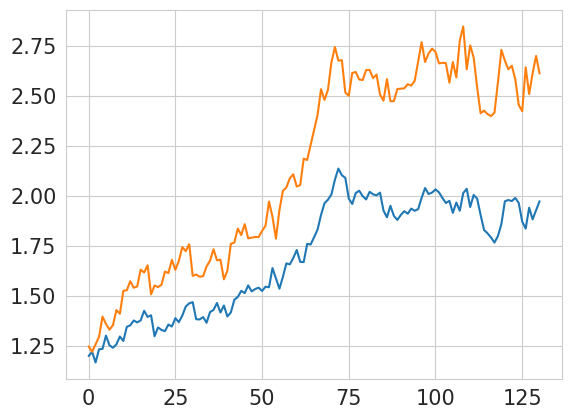

In [ ]:
plt.plot(predictions[:, 10])
plt.plot(y_true[:,10]);